<center>
<h1>CSCI3151 - Foundations of Machine Learning</h1>
<h2>Assignment 1</h2>

<b>Due on: February 6th, 2024  23:59 ADT</b><p>Or by February 14th, 2024  23:59 ADT with a 10% penalty</p>
</center>

### Remember, this assignment is optional!

[Assignment Submission Instructions](https://docs.google.com/document/d/1iHzvkaZzNyZJ54Qw4eXJYOC2vzQUPliMyEBbZVRiS4Q/edit?usp=sharing)


In this assignment you will explore regression and gradient descent, two of the most fundamental building blocks in machine learning and data science. You will also continue exploring creating synthetic data sets (as you already did for A0), one of the most valuable skills in machine learning: creating your own synthetic data set is the best ML debugging tool I know of!

The first step will be to create your dataset (Question 1). Then you will build a regression solver (Question 2). And finally, you will improve your model to make it more powerful (Question 3). For top marks you will also add a regularization term, so that your powerful model isn’t *too* powerful :)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

## **1. Data Generation** ( pts)

You will create a set of functions that generate data which can be used to train a regression model. The regression will ultimately take one input, $x$, and produce one (target) output, $t$. However, your data generation function will also take some parameters, as described next…

### a) Linear Data
First, write a function `generate_line(n=100, xmin=0, xmax=10, c0=0, c1=0)`
that randomly chooses $n$ input points in the interval $[x_{min}, x_{max}]$. For each $x$ in this list it computes a target $t = c_0 + c_1 x$. It returns a list (or `numpy.ndarray`) $[[x_0, t_0], [x_1,t_1], \dots, [x_n,t_n]]$. For example:
```python
data = generate_line(3, 0, 5, 1, 2)
data
>    [[2.39126432027044, 5.78252864054088],
      [3.750966822926141, 8.501933645852283],
      [1.9454086762362344, 4.890817352472469]]
```

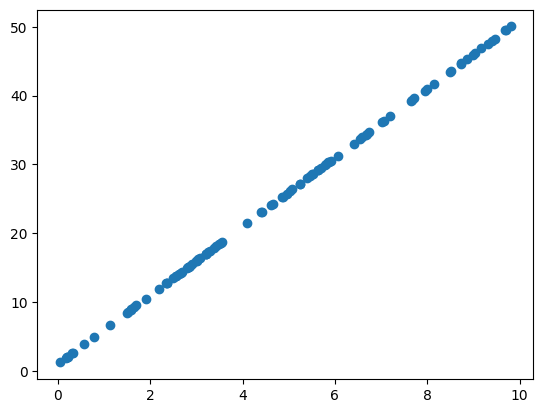

In [ ]:
def generate_line(n=100, xmin=0, xmax=10, c0=0, c1=0):
    # your code here
    arr = np.full(shape=(n,2), fill_value=0, dtype=float)
    for i in range(len(arr)):
      x = np.random.uniform(low=xmin, high=xmax)
      arr[i] = [x, c0 + c1*x]
    return arr

# your plotting code here
linear_data = generate_line(xmin=0, xmax=10, c0=1, c1=5)
plt.scatter(linear_data[:,0], linear_data[:,1])

### b) Polynomial Data
Now modify the above function, to create a new function:

 `generate_poly(n=100, xmin=0, xmax=10, coeffs=[1, 2])`

This is the same as `generate_line`, except that instead of two parameters $c_0$ ane $c_1$, you can provide as an argument a vector $[c_0, c_1, \dots, c_D]$ of arbitrary length $D+1$, where the $c_i$'s  represent the coefficients of a polynomial.

 So for example, if you write:
 `generate_poly(coeffs=[1, 5, 2, -4])`
then this would generate points along the polynomial $t = 1 + 5x + 2x^2 - 4 x^3$.

That is, $\text{coeffs}=[c_0, c_1, \dots, c_D]$ will make your function generate data from the polynomial $t = c_0 + c_1 x + c_2 x^2 + … + c_D x^D$. This function should also return a list (or `numpy.ndarray`) $[[x_0, t_0], [x_1,t_1], \dots, [x_n,t_n]]$.

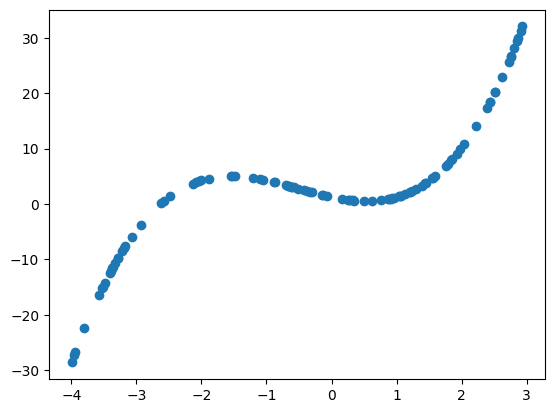

In [ ]:
# try these values for your polynomial!
num_pts = 100
x_min, x_max = (-4, 3)
coefficients = [5/4, -5/2, 3/2, 1]

def generate_poly(n=100, xmin=0, xmax=10, coeffs=[1, 2]):
    # your code here
    arr = np.full(shape=(n,2), fill_value=0, dtype=float)
    for i in range(len(arr)):
      x = np.random.uniform(low=xmin, high=xmax)
      sum = 0
      #coefficients
      for j in range(len(coeffs)):
        sum += coeffs[j]*(x**j)
      arr[i] = [x, sum]
    return arr

polynomial_data = generate_poly(n=num_pts, xmin=x_min, xmax=x_max, coeffs=coefficients)

# your plotting code here
plt.scatter(polynomial_data[:,0], polynomial_data[:,1])

### c) Noisy Polynomial Data.
Finally, rewrite your `generate_poly()` function to use the function `noise(mean, standard_deviation)` below to add random gaussian noise to every generated data point, so that the targets $t$ are
$t = \Sigma_i (c_i x^i) + \text{noise}(\theta, \sigma)$.

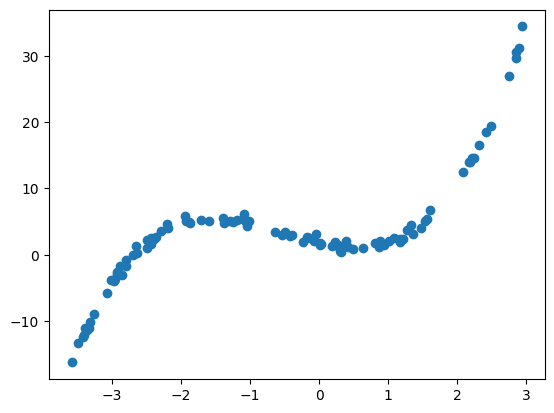

In [ ]:
def noise(mean, standard_deviation):
    return random.gauss(mean, standard_deviation)

def generate_poly_noisy(n=100, xmin=0, xmax=10, coeffs=[1], theta=0.5, sigma=0.5):
    # your code here
    arr = np.full(shape=(n,2), fill_value=0, dtype=float)
    for i in range(len(arr)):
      x = np.random.uniform(low=xmin, high=xmax)
      sum = 0
      #coefficients
      for j in range(len(coeffs)):
        sum += coeffs[j]*(x**j)
      arr[i] = [x, sum + noise(theta, sigma)]
    return arr

polynomial_noisy_data = generate_poly_noisy(n=100, xmin=x_min, xmax=x_max, coeffs=coefficients)

# plot your noisy polynomial data here
plt.scatter(polynomial_noisy_data[:,0], polynomial_noisy_data[:,1])

## **2. Gradient Descent** (12 pts)
In this question we will learn first hand how gradient descent works, in the context of a synthetic dataset and a simple model:

You will write functions that implement gradient descent to fit a linear regression model to data. To test your model and your optimizer, you will use data generated by your function from Question 1.

Note that to keep the assignment short, you are not required to use a validation or test set. Normally this would be an essential part of the process. However, this exercise focuses on the inner workings of gradient descent applied to the quadratic cost function as (was / will be) learned in class.

Your model will have the form

$y = w_0 + w_1 x$,

where $w_0$ and $w_1$ are the parameters of your model, $x$ is the input, and $y$ is your model's prediction.


> Note: It's important that the
code you write is well documented and that no other external package is used (pandas, numpy
are ok).

### a) Linear Regression

Given the values of $x$, we want to fit a linear regression model to predict the $y$ values. We will implement a vectorized version of the gradient descent algorithm. Input ($\mathbf{X}$) and target ($t$) are provided as arguments. $\mathbf{X}$ is modified ($\mathbf{X}_b$) to account for the bias. The coefficients ($\theta$) have been initialized for you. Use Mean Squared Error as the loss function. The shape of the variables $\mathbf{X}$, $t$, and **b** have been given, use this as a guide to output the appropriate shape.

Fill in the gradient descent iteration loop and return the updated `cost_list` and parameters. Please be sure your code is well commented!

> Hint: Some tips for choosing values for the learning rate `lr` and the number of steps to run for `iterations`: this depends greatly on the complexity of your dataset and the sophistication of your model. In this instance the learning rate is can be small, on the order of ~0.001. As for the number of iterations, try running the algorithm for 1000 steps. If it seems the model has stopped learning after fewer, say, 500, reduce the number of iterations and run it again!

In [ ]:
def cost_f(pred, target):
    # E = 1/2N * vec_magnitude(y-t)^2
    mse = (1/(2*(pred.shape[0]))) * (np.linalg.norm(pred - target)**2)
    return mse

def LR(X, t, lr, iterations): # lr = 0.001, iterations = 1000
    # Adding 1 column in X for bias
    b = np.ones((len(X), 1))             # shape : (N, 1)
    X = X.reshape(-1, 1)                 # had to reshape data not in the right format
    X_b = np.append(X, b, axis=1)        # shape : (N, features + 1)
    theta = np.zeros((X_b.shape[1], 1))  # shape : (features + 1, 1)
    t = t.reshape(-1, 1)                 # shape : (N, 1)
    cost_list = []
    weight = []

    for _ in range(iterations):
        # your code here

        # X is the input
        # theta is w = w_0 and b = w_1
        # t is targets
        # change w using gd

        # of form y = xw + b1
        y = np.dot(X_b, theta)
        weight.append(theta)
        cost_list.append(cost_f(y, t))
        # Gradient formula from the extra reading by Roger Grosse
        theta = theta - lr / X_b.shape[0] * np.dot(X_b.T, (y - t))


    return cost_list, np.append(np.append(X, y, axis=1), t, axis=1), theta, weight # return all tested theta, all costs, and final y

We've included a function below to help you visualize your model's predictions. Pass in your dataset with input $\mathbf{X}$ and target $t$, and your model's predictions $y$ and cost list `cost_list` as returned from `LR()` to see them graphed.

In [ ]:
def graph_lr(X, t, y, cost_list, theta):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.title('Model Predictions vs Actual Targets')
    plt.scatter(X, t, c='g', s=10, label="targets")
    plt.scatter(X, y, s=10, c='b', label="predictions")
    plt.plot(X, y, c='r')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.title('Model Cost vs Iteration')
    plt.plot(range(len(cost_list)), cost_list, c='r')
    plt.subplot(1, 3, 3)
    plt.title("Cost vs Weights")
    for j in range(len(theta[0])):
        plt.plot(theta[:, j], cost_list, '-o', label="w"+str(j), markersize=4)
    plt.legend()
    plt.show()

In [ ]:
# Generate noisy linear data for standard GD and stochastic GD
linear_noisy_data = generate_poly_noisy(n=100, xmin=x_min, xmax=x_max, coeffs=[1,1])

w0: [0.99794128]
w1: [1.50251646]

Iterations: 500
MSError: 0.13268724215319228


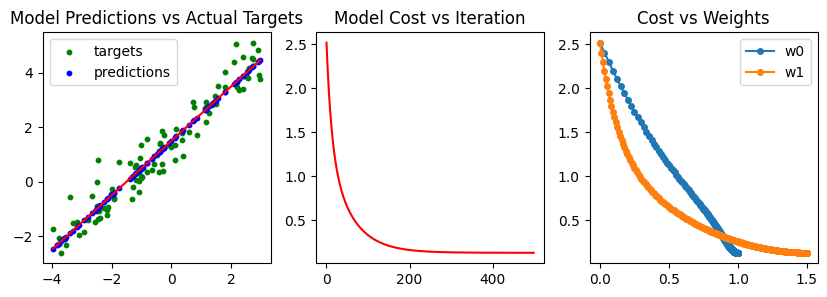

In [ ]:
# plot how loss changes with iterations here
iteration_std = 500 # num of iterations for sgd
learning_rate_std = 0.01 # learning rate for sgd

cost_list, Xyt, theta, weight = LR(linear_noisy_data[:,0], linear_noisy_data[:,1], learning_rate_std, iteration_std)
Xyt_sort = Xyt[Xyt[:, 0].argsort()]
for i in range(len(theta)):
    print(f"w{i}: {theta[i]}")
print(f"\nIterations: {iteration}\nMSError: {cost_list[-1]}")
graph_lr(Xyt_sort[:, 0], Xyt_sort[:, 2], Xyt_sort[:, 1], cost_list, np.array(weight))

### b) Closed Form Solution
Compare this model with a solution computed in closed form. Input ($\mathbf{X}$) and target ($t$) are provided as arguments. $\mathbf{X}$ is modified ($\mathbf{X}_b$) to account for the bias. The function should return the optimum parameter $\theta$.


In [ ]:
from numpy.linalg import inv

def linear_direct(X, t):
  theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, t))

  return theta

In [ ]:
# Parameters found by direct method (closed form)
linear_direct(linear_noisy_data[:,0].reshape(1, -1), linear_noisy_data[:,1].reshape(1, -1)).astype(int)

array([[-197, -194, -139, ...,  -82, -257,  -61],
       [ -47,  -59,  -17, ...,  -13,  -34,   -9],
       [ 833,  737,  504, ...,  290, 1022,  189],
       ...,
       [  21,   19,   11, ...,    7,   27,    5],
       [   4,    1,    0, ...,    1,    3,    0],
       [ -12,  -16,  -14, ...,   -4,  -17,   -4]])

In [ ]:
# Parameters found by gradient descent
theta.astype(int)

array([[0],
       [1]])

### c) Discussion

Discuss how the choice of learning rate and number of iterations in part a) affects the fitting of the model.

Due to a being an iterative process the values we choose for iterations and learning rate can severely affect the accuracy of our model or break it outright. If our learning rate is too big we can miss the minimum and make our loss shoot up to infinity, iterations will affect how many times we pass through the dataset and update our weight, having iteration set too low depending on the learning rate will make us underfit the model and having too much while not necesarilly hurting the model given the learning rate is not too big will consume resources without actually improving our model. The iterative process requires us to find a balance between iterations and learning rate to properly optimize our model

### d) Stochastic Gradient Descent

Write a version of gradient descent that does stochastic gradient descent with mini-batches as described in class. The function will take the same parameters as before, but also an additional parameter `m` that specifies the mini-batch size.

Provide error plots and experiment with different values of mini-batch size `m` and step-size (learning rate `lr`). Show how you can call it so that it works reasonably well, and discuss your observations briefly. Are you able to call it in a way so that it does not work?

In [ ]:
def mini_batch(data, m): # separate data to batches
    row = np.ceil(data.shape[0] / m).astype(int)
    n = 0
    batch = []
    for i in range(row):
        inner_arr = []
        for _ in range(m):
            if n == len(data): # if we reach end of data set
                break
            inner_arr.append(data[n])
            n = n + 1
        # combine the values inside the inner_arr into a single numpy array
        x = np.concatenate(inner_arr)
        batch.append(x.reshape(-1, data.shape[1]))
    # hacky and unelegant but I couldn't think of another solution my numpy isn't super great yet
    return np.asarray(batch, dtype=object)

def stochastic_gradient_descent(X, t, lr, iterations, m = 1):
    b = np.ones((len(X), 1))             # shape : (N, 1)
    X = X.reshape(-1,1)
    X_b = np.append(X, b, axis=1)        # shape : (N, features + 1)
    t = t.reshape(-1, 1)                 # shape : (N, 1)
    theta = np.zeros((X_b.shape[1], 1))  # shape : (features + 1 ,1)
    cost_list = []
    weight = []

    batch = mini_batch(X_b, m)
    #SGD mini-batch
    for _ in range(iterations): # epoch
        # update change after each epoch need to change to same shape as the batch
        y = np.dot(X_b, theta) # predictions
        loss = y - t
        # transform loss to batches so we can use it
        loss = mini_batch(loss, m)
        # update weight using given batch
        weight.append(theta)
        for i in range(len(batch)):
            theta = theta - lr / batch[i].shape[0] * np.dot(batch[i].T, (loss[i]))
        cost_list.append(cost_f(y, t))

    return cost_list, np.append(np.append(X, y, axis=1), t, axis=1), theta, weight


w0: [0.9749436952672836]
w1: [1.477990651783564]

Iterations: 50
MSError: 0.12771427628022322


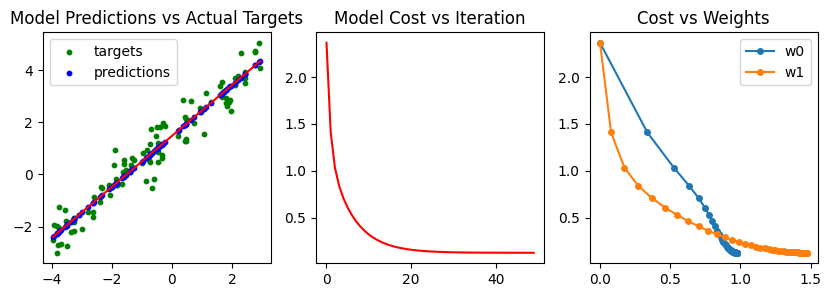

In [ ]:
# your error plot code here
iteration_sgd = 50 # num of iterations for sgd
batch_size_sgd = 1 # how big are the mini-batches
learning_rate_sgd = 0.001 # learning rate for sgd

cost_list, Xyt, theta, weight = stochastic_gradient_descent(linear_noisy_data[:,0], linear_noisy_data[:,1], learning_rate_sgd, iteration_sgd, batch_size_sgd)
Xyt_sort = Xyt[Xyt[:, 0].argsort()]

for i in range(len(theta)):
    print(f"w{i}: {theta[i]}")
print(f"\nIterations: {iteration_sgd}\nMSError: {cost_list[-1]}")

graph_lr(Xyt_sort[:, 0], Xyt_sort[:, 2], Xyt_sort[:, 1], cost_list, np.array(weight))

Convergence is much 'quicker' (quicker in terms of epoch but mini-batching does more calculations and updates) with mini-batching than standard gradient descent, if we look at the epoch it took 2) a. around 500 and 2) d. only took around 50, where SGD stands out is we don't have to calculate the entire input space at once which means less load on our ram allowing us to handle bigger datasets which would most likely crash otherwise.

## **3. Polynomial Features** ( pts)

What happens if you try to fit a linear regression model to cubic data? As you may have observed in the previous question, your model is not powerful enough--all it can really fit well are straight lines! But no need to worry, now you will extend your model by providing it will non-linear features.

### a) Compute the Features

First let's compute the values of these features. Let's assume we know that the relevant features are powers of $x$. For a given $x$, and a given $D$, write a function that takes in $x$ and $D$ and outputs a vector
$[x^0, x^1, x^2, \dots, x^D]$
consisting of the powers of $x$, from $0$ to $D$. So for example, `compute_features(x = 5, D = 3)` will return `[1, 5, 25, 125]`.


In [ ]:
# Compute the features for polynomial regression
def compute_features(x, D):
    # your code here
    arr = []
    for i in range(D + 1):
        arr.append(x**i)
    return arr

compute_features(5, 3)

[1, 5, 25, 125]

### b) Define the Model

Your new model will have the following form: $y = w_0 + w_1 x + \dots w_D x^D$. Compute the derivatives of the cost function with respect to the parameters.


In [ ]:
# your code here

def gradient(X, y, t):
    gradient = 1/X.shape[0] * np.dot(X.T, (y - t))
    return gradient

### c) Implement Gradient Descent

Implement gradient descent and plot your predictions

In [ ]:
# your code here
def PR(X, t, lr, iteration, D):
    theta = np.zeros((D+1, 1))  # shape : (features + 1, 1)
    t = t.reshape(-1, 1)                 # shape : (N, 1)
    cost_list = []
    weight = []

    X_new = []

    for i in X: # New input dataset
        X_new.append(compute_features(i, D))

    X_new = np.array(X_new)

    # learning part of the algo
    for _ in range(iteration):
        y = np.dot(X_new, theta)
        cost_list.append(cost_f(y, t))
        weight.append(theta)
        theta = theta - lr * gradient(X_new, y, t)

    return cost_list, np.append(np.append(X.reshape(-1,1), y, axis=1), t, axis=1), theta, weight

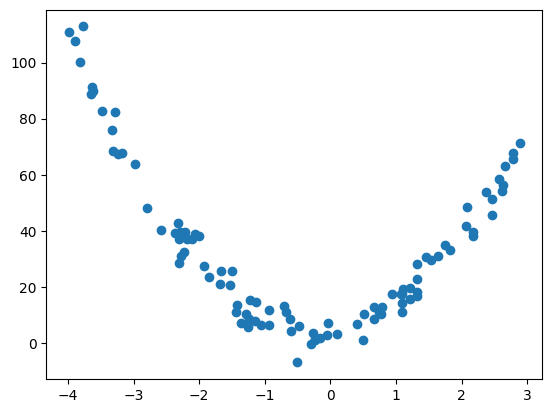

In [ ]:
polynomial_noisy_data = generate_poly_noisy(n=100, xmin=x_min, xmax=x_max, coeffs=[1, 2, 7], theta = 5, sigma = 5)
plt.scatter(polynomial_noisy_data[:,0], polynomial_noisy_data[:,1])

w0: [1.85809077]
w1: [1.63327499]
w2: [7.42361611]

Iterations: 500
MSError: 12.937465046948317


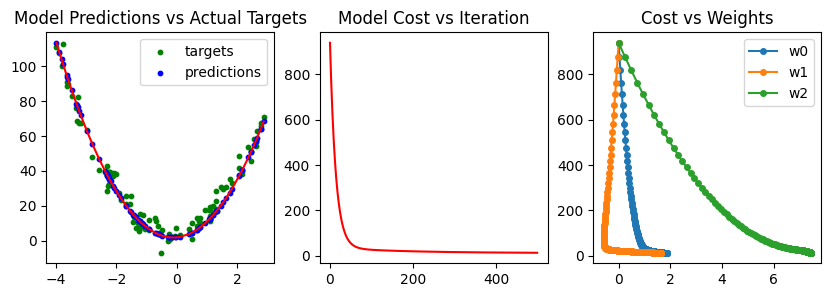

In [ ]:
# your plotting code here
iteration_PR = 500

cost_list, Xyt, theta, weight = PR(polynomial_noisy_data[:, 0], polynomial_noisy_data[:, 1], 0.001, iteration_PR, 2)
Xyt_sort = Xyt[Xyt[:, 0].argsort()]

#print('''np.array(weight)[:, 0].reshape(1,-1),''', cost_list)

for i in range(len(theta)):
    print(f"w{i}: {theta[i]}")
print(f"\nIterations: {iteration_PR}\nMSError: {cost_list[-1]}")
graph_lr(Xyt_sort[:, 0], Xyt_sort[:, 2], Xyt_sort[:, 1], cost_list, np.array(weight))

### d) Regularization & SGD (for A+)

Here you need to do two things:
1. Add a regularization term  to the loss function, $\text{Loss_reg} = sum (w_i)^2$ the sum of the squares of the weights. That is, the model will be penalized for large weights.
2. Compute the derivative of the loss with respect to this term, and add it to the gradient computation. This should make the gradients cause the weights to gradually decrease, unless they are actively useful for the model.

Use stochastic gradient descent. This means that instead of computing the gradient on the entire dataset, you will now just work with a few examples at a time. Your gradient descent function can now also take a `batch_size`, so that it randomly selects that size of subset from the full example set.


In [ ]:
# your code here
def mini_batch(data, m): # separate data to batches
    row = np.ceil(data.shape[0] / m).astype(int)
    n = 0
    batch = []
    for i in range(row):
        inner_arr = []
        for _ in range(m):
            if n == len(data): # if we reach end of data set
                break
            inner_arr.append(data[n])
            n = n + 1
        # combine the values inside the inner_arr into a single numpy array
        x = np.concatenate(inner_arr)
        batch.append(x.reshape(-1, data.shape[1]))
    # hacky and unelegant but I couldn't think of another solution my numpy isn't super great yet
    return np.asarray(batch, dtype=object)


def sgd_pr(X, t, lr, iteration, m, D):
    theta = np.zeros((D+1, 1))          # shape : (features + 1, 1)
    t = t.reshape(-1, 1)                # shape : (N, 1)
    cost_list = []
    weight = []

    # Computing Features
    X_new = []
    for i in X: # New input dataset
        X_new.append(compute_features(i, D))
    X_new = np.array(X_new)

    # Split to batches
    batch = mini_batch(X_new, m)

    # Learning part of the algo
    for _ in range(iteration):
        y = np.dot(X_new, theta) # predictions
        loss = y - t
        # transform loss to batches so we can use it
        loss = mini_batch(loss, m)
        cost_list.append(cost_f(y, t)) # cost every epoch for graphing
        weight.append(theta) # weight every epoch for graphing
        for i in range(len(batch)):
            theta = theta - lr / batch[i].shape[0] * np.dot(batch[i].T, (loss[i]))

    return cost_list, np.append(np.append(X.reshape(-1,1), y, axis=1), t, axis=1), theta, weight

## **Bonus: Validation and Testing** ( pts)

Revise your answers for Questions 2 and 3 and add code where needed so that your graphs also show results on a validation set.

w0: [3.490253458735273]
w1: [2.3610560269746728]
w2: [7.362223970627566]

Iterations: 50
MSError: 10.489369800207525


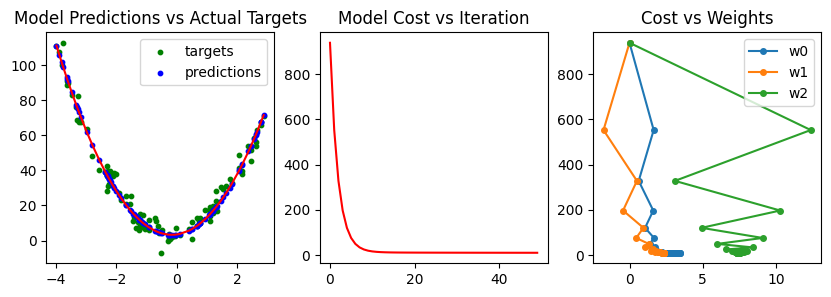

In [ ]:
# your code here
iteration_sgd_pr = 50 # num of iterations for sgd
batch_size_sgd_pr = 2 # how big are the mini-batches
learning_rate_sgd_pr = 0.001 # learning rate for sgd

cost_list, Xyt, theta, weight = sgd_pr(polynomial_noisy_data[:,0], polynomial_noisy_data[:,1], learning_rate_sgd_pr, iteration_sgd_pr, batch_size_sgd_pr, 2)
Xyt_sort = Xyt[Xyt[:, 0].argsort()]

for i in range(len(theta)):
    print(f"w{i}: {theta[i]}")
print(f"\nIterations: {iteration_sgd_pr}\nMSError: {cost_list[-1]}")

graph_lr(Xyt_sort[:, 0], Xyt_sort[:, 2], Xyt_sort[:, 1], cost_list, np.array(weight))